In [121]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [242]:
# auto grad set up begin

# value object class
class Value:
    def __init__(self, data, _children =(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev =  set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    # define operators on value objects
    def __add__(self, val):
        # account for non value abjoect
        val = val if isinstance(val, Value) else Value(val)

        output = Value(self.data + val.data, (self,val), '+')
        # chain rule implement
        def _backward():
            self.grad += 1.0* output.grad
            val.grad += 1.0* output.grad 

        output._backward =_backward
        return output
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, val):
        return self +(-val) 
    
    def __mul__(self, val):
        # account for non value abjoect
        val = val if isinstance(val, Value) else Value(val)
        
        output = Value(self.data * val.data, (self,val), '*')

        # chain rule implement
        def _backward():
            self.grad += val.data * output.grad
            val.grad += self.data * output.grad

        output._backward =_backward
        return output
    
    def __truediv__(self, val):
        out = self * val**-1
        return out
    
    def __pow__(self, val):
        assert isinstance(val, (int,float)), "Does not support this data type: integers and floating point numbers only."
        output = Value(self.data**val, (self,), f'**{val}')

        def _backward():
            self.grad += val *(self.data ** (val-1)) * output.grad
        output._backward = _backward

        return output
        
    # redefine order for int * Value
    def __rmul__(self, val):
        return self * val
    
    def __radd__(self, val):
        return self + val  # This will call the __add__ method
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2*x)+1)

        output = Value(t, (self,), 'tanh')

        # implement chain rule
        def _backward():
            self.grad += (1-(t**2))* output.grad
        
        output._backward = _backward

        return output
    
    def exp(self):
        x =  self.data
        output =  Value(math.exp(x), (self,), 'exp')
    
        def _backward():
            self.grad = output.data * output.grad
        output._backward = _backward
        
        return output


    def backward(self):
        # backprop implementation with topological sort --> cannot call _baclward() on child before parent
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        # set base cased for first grad
        self.grad = 1.0

        # build list
        build_topo(self)

        for node in reversed(topo):
            node._backward()






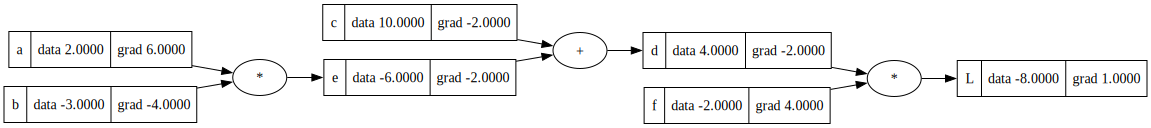

In [43]:
# implement graph tracing using graphviz API

from graphviz import Digraph

# implement trace to build set of nodes and edges
def trace(root):
    nodes,edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={"rankdir": 'LR'}) # left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        # for value in graph, create a rectagular node 
        dot.node(name= uid, label = "{%s | data %.4f| grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')

        if n._op:
            # if this val is a result of op then create of op node for it
            dot.node(name=uid + n._op, label = n._op)
            # coneect edge
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+ n2._op)
    return dot


In [220]:

# input x1,x2
x1 = Value(2.0, label ='x1')
x2 = Value(0.0, label ='x2')


# weights w1, w2
w1 = Value(-3.0, label ='w1')
w2 = Value(1.0, label ='w2')

# bias for neuron
b = Value(6.8813735870195432, label = 'b')

# w1*x1 +w2*x2 +b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2 ;x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 +b; n.label = 'n'

# activation function
o = n.tanh(); o.label = 'output'



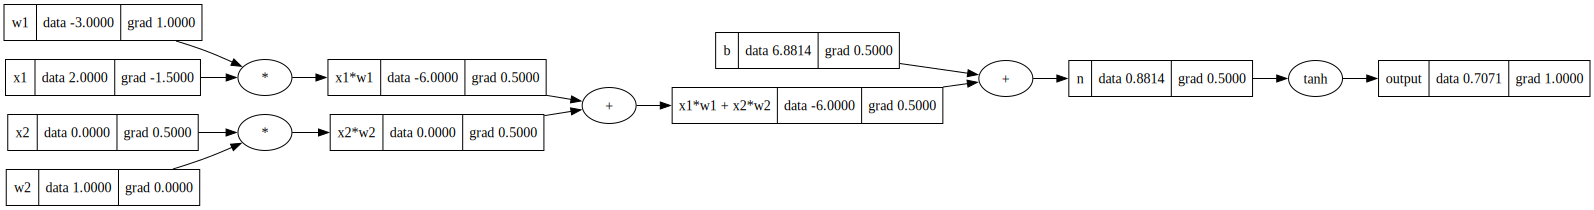

In [221]:
# manual implementation for illutrative purposes--> updated micrograd to handle on call

# o.grad = 1.0

# # d0/dn = 1-(tanhn)**2 = 1-o**2
# n.grad = 1- (o.data)**2

# # local derivates based on addition so previous derivatives flow to following due to chain rule rendering their local derivatives 1
# x1w1x2w2.grad = 1*(n.grad)
# b.grad = 1*(n.grad)

# # same thing happens here
# x1w1.grad = 1*(x1w1x2w2.grad)
# x2w2.grad = 1*(x1w1x2w2.grad)

# # now we have multiplication: chain rule for partial derivatives
# x1.grad = w1.data * x1w1.grad  
# x2.grad = w2.data * x2w2.grad  
# w1.grad = x1.data * x1w1.grad 
# w2.grad = x2.data * x2w2.grad


# call backward for backprop
o.backward()


draw_dot(o)


In [223]:
# vanilla MLP implementation

class Neuron:
    def __init__(self, ninput):
        self.weights = [Value(random.uniform(-1,1)) for _ in range(ninput)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # dot prod
        act = sum((wi*xi for wi, xi in zip(self.weights, x)), self.b)
        output = act.tanh()
        return output
    def parameters(self):
        return self.weights + [self.b]

        

class Layer:

    def __init__(self, ninput, noutput):
        self.neurons = [Neuron(ninput) for _ in range(noutput)]
        
    def __call__(self,x):
        output = [n(x) for n in self.neurons]
        return output[0] if len(output) == 1 else output
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP:

    def __init__(self, ninput, noutput):
        size = [ninput] + noutput
        self.layers  = [Layer(size[i], size[i + 1]) for i in range(len(noutput))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

x = [2.0,3.0,-1.0]
n = MLP(3, [4,4,1])
n(x)
    

Value(data=0.2918095242649275)

In [292]:
x = [2.0,3.0,-1.0]
n = MLP(3, [4,4,1])
n(x)



# data for testing network

feat = [[2.0, 3.0, -1.0],
        [3.0, -1.0, 0.5],
        [0.5, 1.0, 1.0],
        [1.0, 1.0, -1.0],]

labels = [1.0, -1.0, -1.0, 1.0]




In [293]:
# forward pass
for i in range(50):
    ypredict = [n(x) for x in feat]
    
    # define loss
    loss = sum((youtput - ygtruth)**2 for ygtruth, youtput in zip(labels, ypredict))
   
    # zero grad reset
    for p in n.parameters():
        p.grad =0.0

    # backward pass
    loss.backward()

    # update    
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(i, loss.data)

0 6.898403304590239
1 3.8417132834197
2 3.1606266954135016
3 2.6439265596287096
4 2.448463345622825
5 1.4088042011212312
6 0.20659005218240312
7 0.06372941245388268
8 0.04838129254024211
9 0.03980848772607166
10 0.03409759869658825
11 0.02993001792641195
12 0.026714762004375316
13 0.024139833926208352
14 0.02202167127908983
15 0.02024362426040925
16 0.01872718915453561
17 0.017417151560134913
18 0.016273300918208247
19 0.01526551841413043
20 0.014370716263705424
21 0.013570850470522929
22 0.012851585259350547
23 0.012201368815401643
24 0.011610777406947013
25 0.011072039740790025
26 0.010578685422093765
27 0.010125280767695014
28 0.009707227309731292
29 0.009320606072517706
30 0.008962055790214564
31 0.00862867664304686
32 0.008317953421842838
33 0.008027693653562066
34 0.007755977368042284
35 0.0075011160094963295
36 0.007261618594864269
37 0.007036163661649878
38 0.006823575875742284
39 0.0066228064162971705
40 0.006432916441979756
41 0.006253063086313077
42 0.006082487540692551
43 0

In [294]:
ypredict

[Value(data=0.9665496945874635),
 Value(data=-0.972981208575399),
 Value(data=-0.9554598842348714),
 Value(data=0.9644292059210701)]